In [21]:
import cv2
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt


def extract_bounding_box(image_path, xml_path):
    # Load the image
    image = cv2.imread(image_path)

    # Parse the XML file
    tree = ET.parse(xml_path)
    root = tree.getroot()

    # Extract bounding box coordinates
    for obj in root.findall(".//object"):
        bndbox = obj.find("bndbox")
        xmin = int(bndbox.find("xmin").text)
        ymin = int(bndbox.find("ymin").text)
        xmax = int(bndbox.find("xmax").text)
        ymax = int(bndbox.find("ymax").text)

        # Crop the bounding box from the image
        cropped_image = image[ymin:ymax, xmin:xmax]

        # Save or display the cropped image
    plt.imshow(image)
    # plt.imshow(cropped_image)


# Example usage
image_path = "archive(2)/05102009102.jpg"
xml_path = "archive(2)/05102009102.xml"


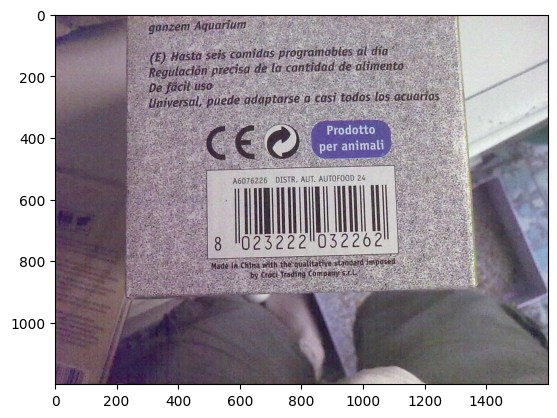

In [22]:
extract_bounding_box(image_path, xml_path)

In [23]:
import os
import shutil


def move_xml_files(source_dir, destination_dir):
    if not os.path.exists(destination_dir):
        os.makedirs(destination_dir)

    # Iterate through all files in the source directory
    for file in os.listdir(source_dir):
        if file.endswith(".xml"):
            source_path = os.path.join(source_dir, file)
            destination_path = os.path.join(destination_dir, file)

            # Move the XML file
            shutil.move(source_path, destination_path)


# Example usage
source_directory = "archive(2)"
destination_directory = "xml_files"

move_xml_files(source_directory, destination_directory)

In [24]:
import cv2
import os
import xml.etree.ElementTree as ET


def extract_bounding_boxes(image_dir, xml_dir, output_dir):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Iterate through all XML files
    for xml_file in os.listdir(xml_dir):
        if not xml_file.endswith(".xml"):
            continue

        # Parse the XML file
        xml_path = os.path.join(xml_dir, xml_file)
        tree = ET.parse(xml_path)
        root = tree.getroot()

        # Load the corresponding image
        image_file = root.find(".//filename").text
        image_path = os.path.join(image_dir, image_file)
        image = cv2.imread(image_path)

        # Extract bounding boxes
        for i, obj in enumerate(root.findall(".//object")):
            bndbox = obj.find("bndbox")
            xmin = int(bndbox.find("xmin").text)
            ymin = int(bndbox.find("ymin").text)
            xmax = int(bndbox.find("xmax").text)
            ymax = int(bndbox.find("ymax").text)

            # Crop the bounding box from the image
            cropped_image = image[ymin:ymax, xmin:xmax]

            # Generate a unique filename for each cropped barcode
            output_filename = f"{os.path.splitext(image_file)[0]}_barcode_{i}.jpg"
            output_path = os.path.join(output_dir, output_filename)

            # Save the cropped image
            cv2.imwrite(output_path, cropped_image)


# Example usage
image_directory = "archive(2)"
xml_directory = "xml_files"
output_directory = "barcode_images"

extract_bounding_boxes(image_directory, xml_directory, output_directory)


In [1]:
import cv2
import numpy as np

def calculate_optimal_layers(image):
    height, width = image.shape[:2]
    # Number of layers depends on the smallest dimension
    return int(np.log2(min(height, width))) - 1

img = cv2.imread('barcode_images/05102009102_barcode_1.jpg', cv2.IMREAD_GRAYSCALE)
num_layers = calculate_optimal_layers(img)
print("Optimal Layers:", num_layers)


Optimal Layers: 5


In [2]:
!pip install realesrgan

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 1.9 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 1.9 MB/s eta 0:00:00a 0:00:01
  Created wheel for basicsr: filename=basicsr-1.4.2-py3-none-any.whl size=214818 sha256=cdf8f88f6aff5b31847918a365a6f98f864a1cbd21baaa086da3e2be5763117a
  Stored in directory: /home/roy/.cache/pip/wheels/6d/a4/b3/9f888ba88efcae6dd4bbce69832363de9c4051142674f779fa
  Created wheel for filterpy: filename=filterpy-1.4.5-py3-none-any.whl size=110460 sha256=75d1d22e196eb63fc6e80fa408ca008561405ca20439bb99f7c05d5f7d88853c
  Stored in directory: /home/roy/.cache/pip/wheels/12/dc/3c/e12983eac132d00f82a20c6cbe7b42ce6e96190ef8fa2d15e1
Successfully built basicsr filterpy


In [ ]:
import cv2
import numpy as np
from realesrgan import RealESRGAN
import matplotlib.pyplot as plt
img = cv2.imread('blurry_barcode.jpg', cv2.IMREAD_GRAYSCALE)

def laplacian_pyramid(img, levels=7):
    gaussian_pyr = [img]
    for i in range(levels):
        img = cv2.GaussianBlur(img, (5, 5), 0)
        gaussian_pyr.append(img)
    return gaussian_pyr

def focus_stack(layers):
    sharp_layers = []
    for layer in layers[3:]:  # Skip low frequencies
        edges = cv2.Laplacian(layer, cv2.CV_64F)
        sharp_layers.append(edges)
    return sum(sharp_layers) / len(sharp_layers)

def enhance_with_esrgan(image):
    model = RealESRGAN('RealESRGAN_x4plus')
    return model.predict(image)

pyramid = laplacian_pyramid(img)

sharp_image = focus_stack(pyramid)

enhanced = enhance_with_esrgan(sharp_image)

# Plot all 3 images
plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
plt.title("Original Blurry Barcode")
plt.imshow(img, cmap='gray')

plt.subplot(1, 3, 2)
plt.title("After Focus Stacking")
plt.imshow(sharp_image, cmap='gray')

plt.subplot(1, 3, 3)
plt.title("Final Unblurred Barcode (ESRGAN Enhanced)")
plt.imshow(enhanced, cmap='gray')

plt.show()